# ReRun: Middle Atmosphere Forcings

In [1]:
import sys, os, glob
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

In [40]:
import pylab as plt
import seaborn as sns
import importlib

sns.set_context('talk')

colors = plt.rcParamsDefault["axes.prop_cycle"].by_key()["color"]
ora = colors.pop(1)
colors.insert(2, ora)

myPara = {'figure.figsize': (14,7), 'lines.linewidth': 3, 'legend.frameon' : False,
          'axes.spines.right': False,
          'axes.spines.top': False,
          'axes.titleweight': 'bold',
          "axes.prop_cycle": plt.cycler(color=colors)
         }
                            
plt.rcParams.update( myPara )



In [41]:
for pname in plt.rcParams:
    if 'linewidth' in pname:
        print( pname, plt.rcParams[pname])

axes.linewidth 1.875
boxplot.boxprops.linewidth 1.0
boxplot.capprops.linewidth 1.0
boxplot.flierprops.linewidth 1.0
boxplot.meanprops.linewidth 1.0
boxplot.medianprops.linewidth 1.0
boxplot.whiskerprops.linewidth 1.0
contour.linewidth None
grid.linewidth 1.5
hatch.linewidth 1.0
lines.linewidth 3.0
patch.linewidth 1.5


## Open Data

*Data Description*:

* ensembles are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_gfas2020_injtrp+1_pcb_ao_ens`
    * ensemble data two subdirs as hierachical structure
    
* nudged data are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_nu_gfas2020_injtrp+1_pcb_ao`


In [42]:
sys.path.append('../tools')

import importlib
import reader, plot, analysis
importlib.reload( reader )
importlib.reload( plot )
importlib.reload( analysis )
from analysis import ens_stat


In [5]:
dset = reader.read_wifiaus_combination( file_type = 'echam')
forcing = reader.read_wifiaus_combination( file_type = 'forcing' )

## List Content

In [6]:
for vname in sorted( dset.data_vars ):
    try:
        print( vname, dset[vname].long_name, dset[vname].units )

    except:
        try:
            print( vname, dset[vname].long_name )
        except:
            print(vname)

abso4 antropogenic sulfur burden kg/m**2
aclcac cloud cover
aclcov total cloud cover
ahfcon conductive heat flux through ice W/m**2
ahfice conductive heat flux W/m**2
ahfl latent heat flux W/m**2
ahfliac latent heat flux over ice W/m**2
ahfllac latent heat flux over land W/m**2
ahflwac latent heat flux over water W/m**2
ahfres melting of ice W/m**2
ahfs sensible heat flux W/m**2
ahfsiac sensible heat flux over ice W/m**2
ahfslac sensible heat flux over land W/m**2
ahfswac sensible heat flux over water W/m**2
albedo surface albedo
albedo_nir surface albedo NIR range
albedo_nir_dif surface albedo NIR range diffuse
albedo_nir_dir surface albedo NIR range direct
albedo_vis surface albedo visible range
albedo_vis_dif surface albedo visible range diffuse
albedo_vis_dir surface albedo visible range direct
alsobs albedo of bare ice and snow without ponds
alsoi albedo of ice
alsol albedo of land
alsom albedo of melt ponds
alsow albedo of water
ameltdepth total melt pond depth m
ameltfrac fract 

## Analysis 

* **atmospheric forcing**

$$
F_{net, atm} = F_{net, TOA} - F_{net, surf}
$$

In [7]:
F_sw_atm = dset['srad0'] - dset['srads']
F_sw_atm.attrs['long_name'] = 'solar radiation absorb. in atm.'

dset['F_sw_atm'] = F_sw_atm


In [8]:
F_lw_atm = dset['trad0'] - dset['trads']
F_lw_atm.attrs['long_name'] = 'terrestrial radiation absorb. in atm.'

dset['F_lw_atm'] = F_lw_atm


In [9]:
F_net_atm = F_sw_atm + F_lw_atm
F_net_atm.attrs['long_name'] = 'net radiation absorb. in atm.'

dset['F_net_atm'] = F_net_atm


* **middle atmosphere forcing**
$$
F_{net, MA} = F_{net, TOA} - F_{net, 200hPa}
$$

In [10]:
F_sw_MA = dset['srad0'] - dset['sradl']
F_sw_MA.attrs['long_name'] = 'solar radiation absorb. in middle atm.'

dset['F_sw_MA'] = F_sw_MA


In [11]:
F_lw_MA = dset['trad0'] - dset['tradl']
F_lw_MA.attrs['long_name'] = 'terrestrial radiation absorb. in middle atm.'

dset['F_lw_MA'] = F_lw_MA


In [12]:
F_net_MA = F_sw_MA + F_lw_MA
F_net_MA.attrs['long_name'] = 'net radiation absorb. in middle atm.'

dset['F_net_MA'] = F_net_MA


* **lower atmosphere forcing**
$$
F_{net, LA} = F_{net, 200hPa} - F_{net, surf}
$$

In [13]:
F_sw_LA = dset['sradl'] - dset['srads']
F_sw_LA.attrs['long_name'] = 'solar radiation absorb. in lower atm.'

dset['F_sw_LA'] = F_sw_LA


In [14]:
F_lw_LA = dset['tradl'] - dset['trads']
F_lw_LA.attrs['long_name'] = 'terrestrial radiation absorb. in lower atm.'

dset['F_lw_LA'] = F_lw_LA


In [15]:
F_net_LA = F_sw_LA + F_lw_LA
F_net_LA.attrs['long_name'] = 'net radiation absorb. in lower atm.'

dset['F_net_LA'] = F_net_LA


* **net TOA Forcing**

In [16]:
F_net_TOA = dset['srad0'] + dset['trad0']

F_net_TOA.attrs['long_name'] = 'net TOA radiation'

dset['F_net_TOA'] = F_net_TOA


* **net surface Forcing**

In [17]:
F_net_surf = dset['srads'] + dset['trads']

F_net_surf.attrs['long_name'] = 'net surf. radiation'

dset['F_net_surf'] = F_net_surf


* **radiative fluxes without aerosol impacts**

$$
F_{sw, surf, no aer} = F_{sw, surf} - \Delta F_{sw, surf, aer}
$$

In [18]:
dset['F_sw_surf_noaer'] = dset['srads'] - forcing['FSW_TOTAL_SUR']
dset['F_sw_toa_noaer']  = dset['srad0'] - forcing['FSW_TOTAL_TOP']

dset['F_sw_surf_noaer_clear'] = dset['srafs'] - forcing['FSW_CLEAR_SUR']
dset['F_sw_toa_noaer_clear']  = dset['sraf0'] - forcing['FSW_CLEAR_TOP']



## Plotting

### Radiation Vars 

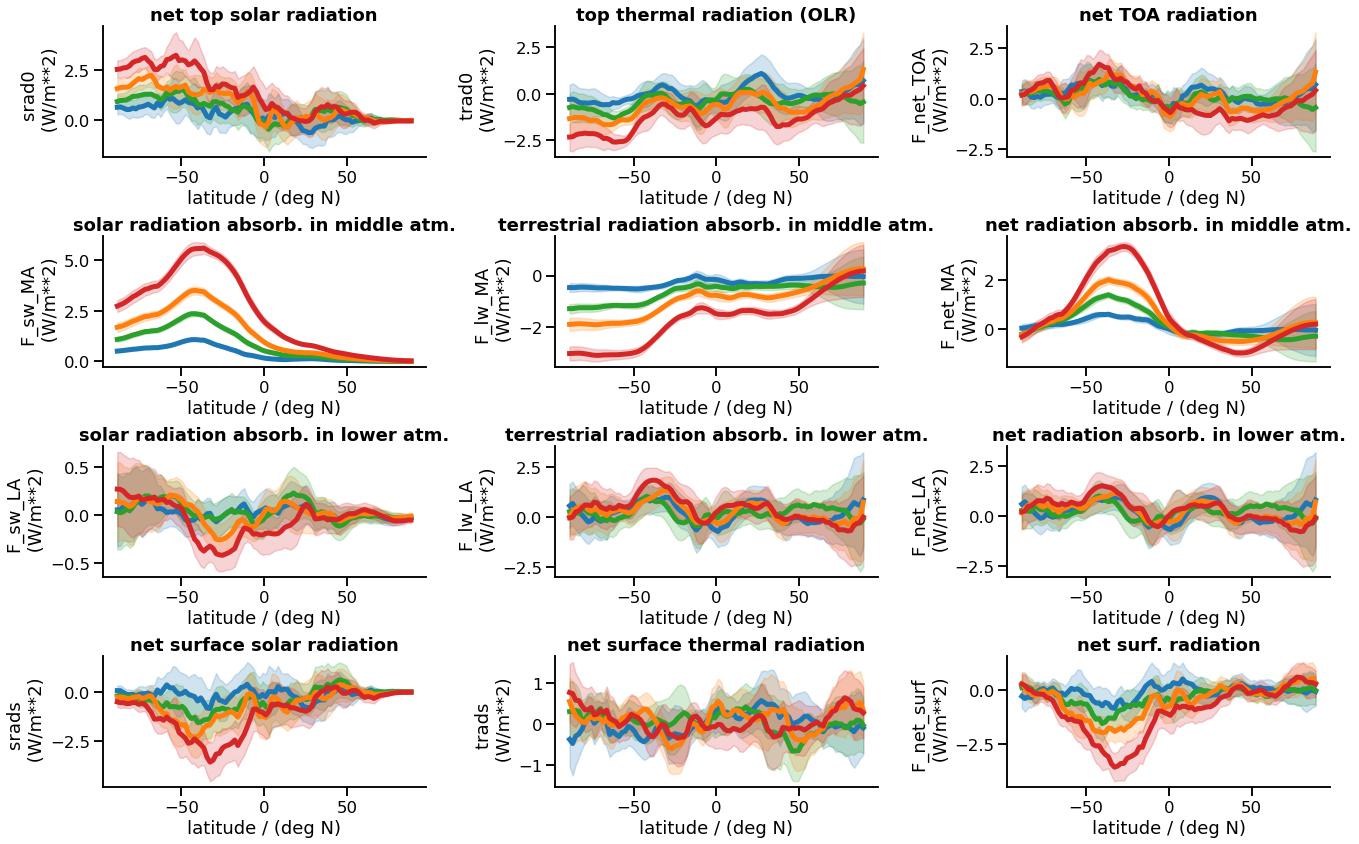

In [19]:
fig, axs = plt.subplots( ncols = 3, nrows = 4, figsize = (22,14))
plt.subplots_adjust( wspace = 0.4, hspace = 0.6)
axs = axs.flatten()

vlist = ['srad0', 'trad0', 'F_net_TOA',
#          'F_sw_atm', 'F_lw_atm', 'F_net_atm', 
         'F_sw_MA', 'F_lw_MA', 'F_net_MA',
         'F_sw_LA', 'F_lw_LA', 'F_net_LA',
         'srads', 'trads', 'F_net_surf']

for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff(dset[vlist[i]])

plt.savefig('../pics4paper/radfluxes-by-latitude.jpg')

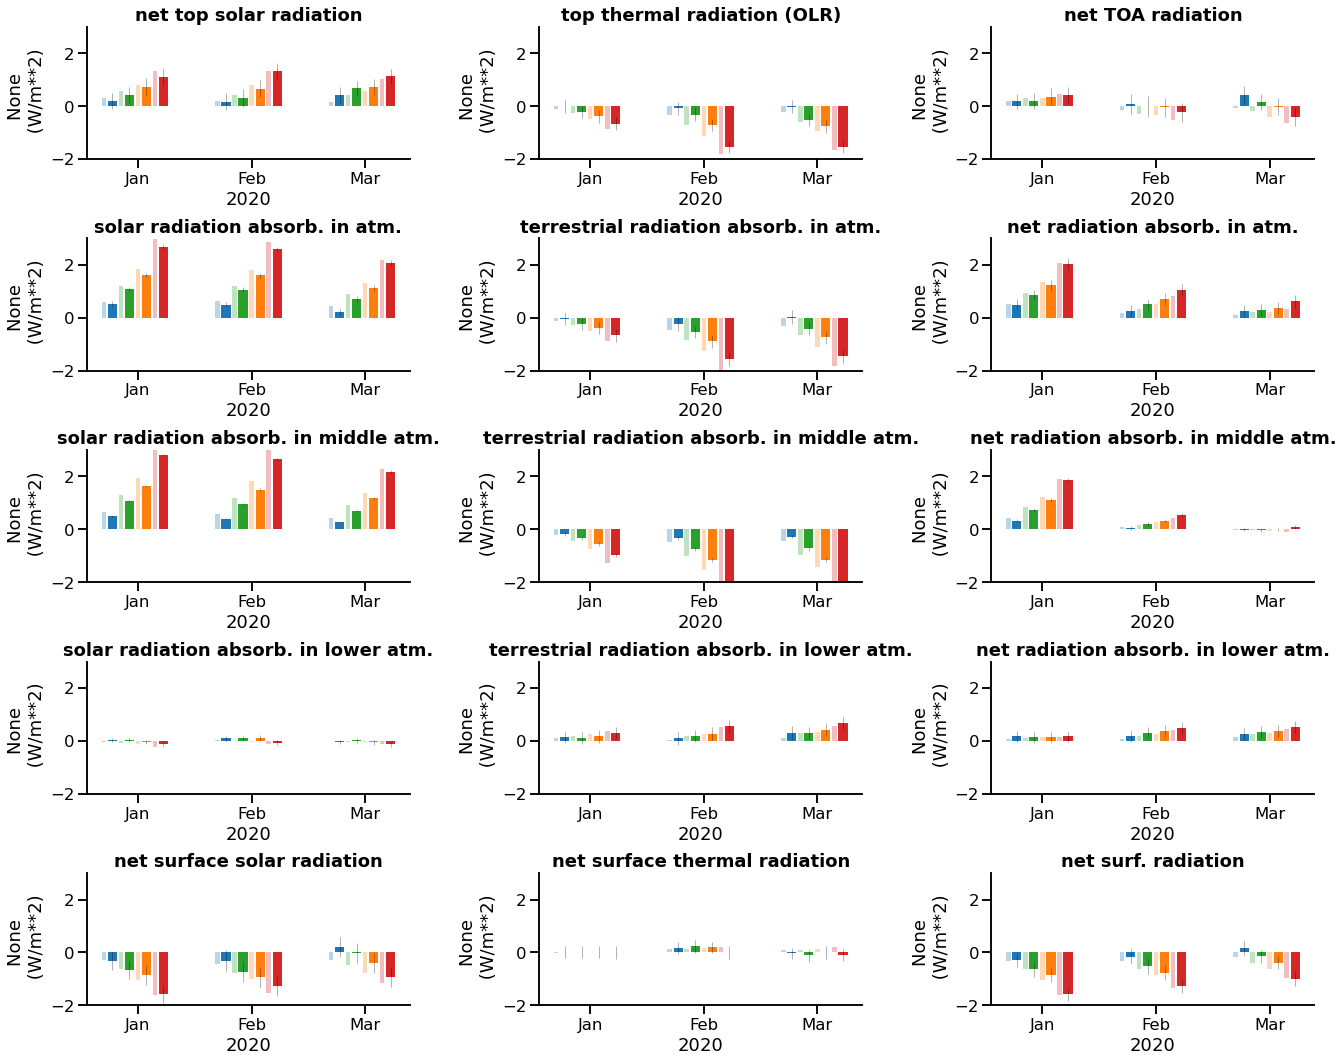

In [20]:
fig, axs = plt.subplots( ncols = 3, nrows = 5, figsize = (22,18))
plt.subplots_adjust( wspace = 0.4, hspace = 0.6)
axs = axs.flatten()

vlist = ['srad0', 'trad0', 'F_net_TOA',
          'F_sw_atm', 'F_lw_atm', 'F_net_atm', 
         'F_sw_MA', 'F_lw_MA', 'F_net_MA',
         'F_sw_LA', 'F_lw_LA', 'F_net_LA',
         'srads', 'trads', 'F_net_surf']

for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff_ts(dset[vlist[i]], method = 'globalmean', style = 'bar', add_nudged = True)
    axs[i].set_ylim(-2,3)

### Radiation with no Aerosol

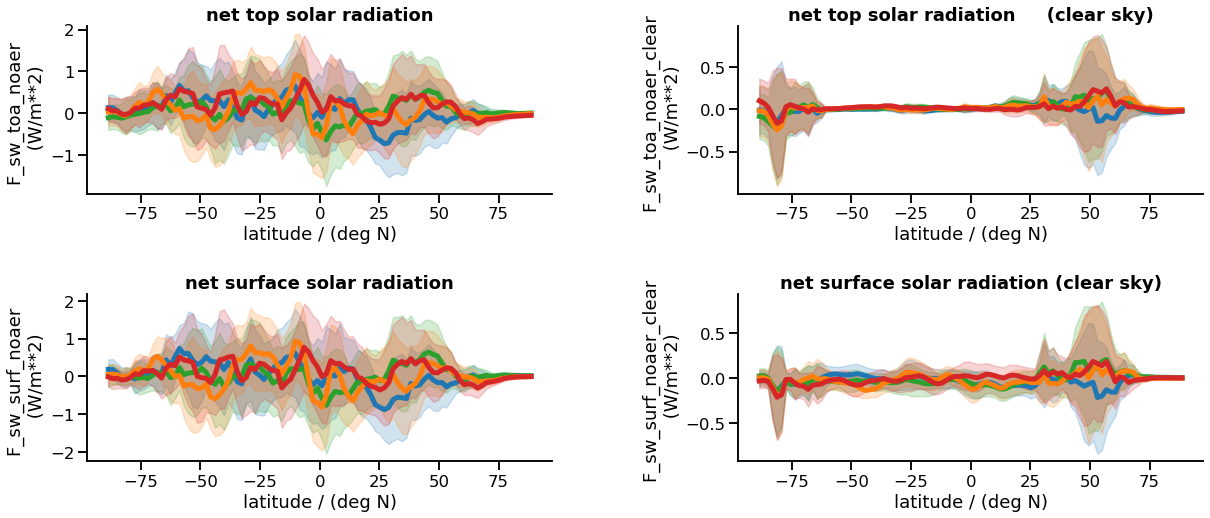

In [21]:
fig, axs = plt.subplots( ncols = 2, nrows = 2, figsize = (20,8))
plt.subplots_adjust( wspace = 0.4, hspace = 0.6 )
axs = axs.flatten()

vlist = ['F_sw_toa_noaer', 'F_sw_toa_noaer_clear',
         'F_sw_surf_noaer', 'F_sw_surf_noaer_clear',]

for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff(dset[vlist[i]])

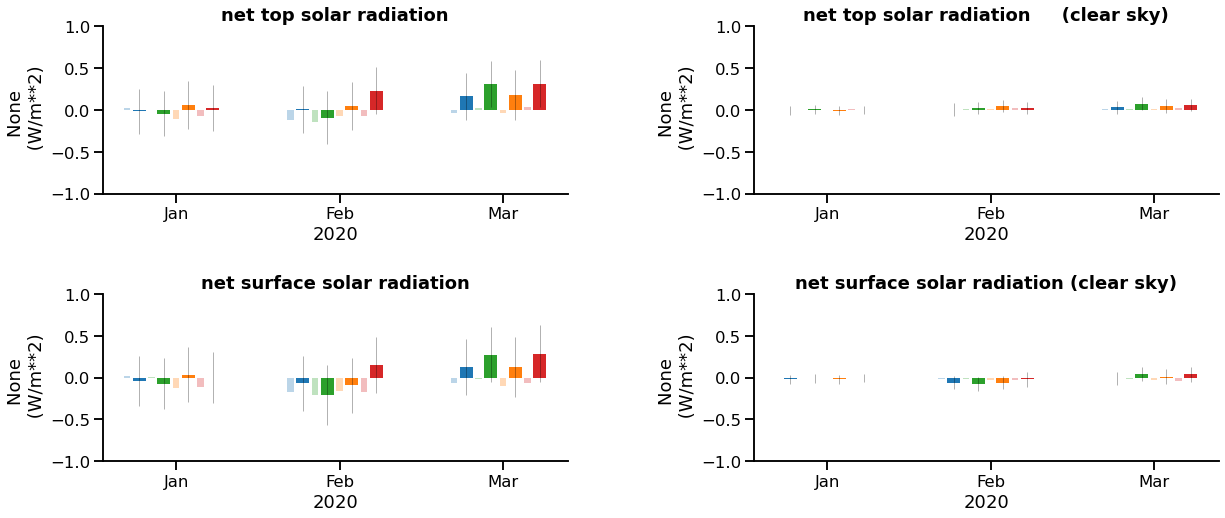

In [22]:
fig, axs = plt.subplots( ncols = 2, nrows = 2, figsize = (20,8))
plt.subplots_adjust( wspace = 0.4, hspace = 0.6 )
axs = axs.flatten()

vlist = ['F_sw_toa_noaer', 'F_sw_toa_noaer_clear',
         'F_sw_surf_noaer', 'F_sw_surf_noaer_clear',]

for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff_ts(dset[vlist[i]], method = 'globalmean', style = 'bar', add_nudged = True)
    axs[i].set_ylim(-1,1)

### Water Vars Again

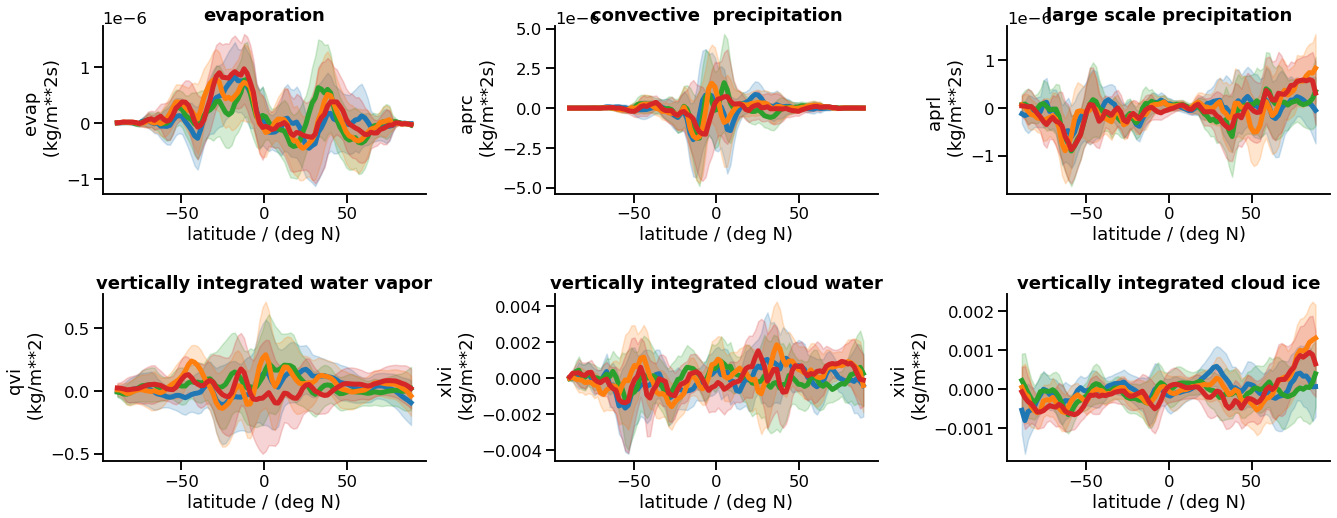

In [23]:
fig, axs = plt.subplots( ncols = 3, nrows = 2, figsize = (22,8))
plt.subplots_adjust( wspace = 0.4, hspace = 0.6)
axs = axs.flatten()

vlist = ['evap', 'aprc', 'aprl', 'qvi', 'xlvi', 'xivi']

for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff(dset[vlist[i]])

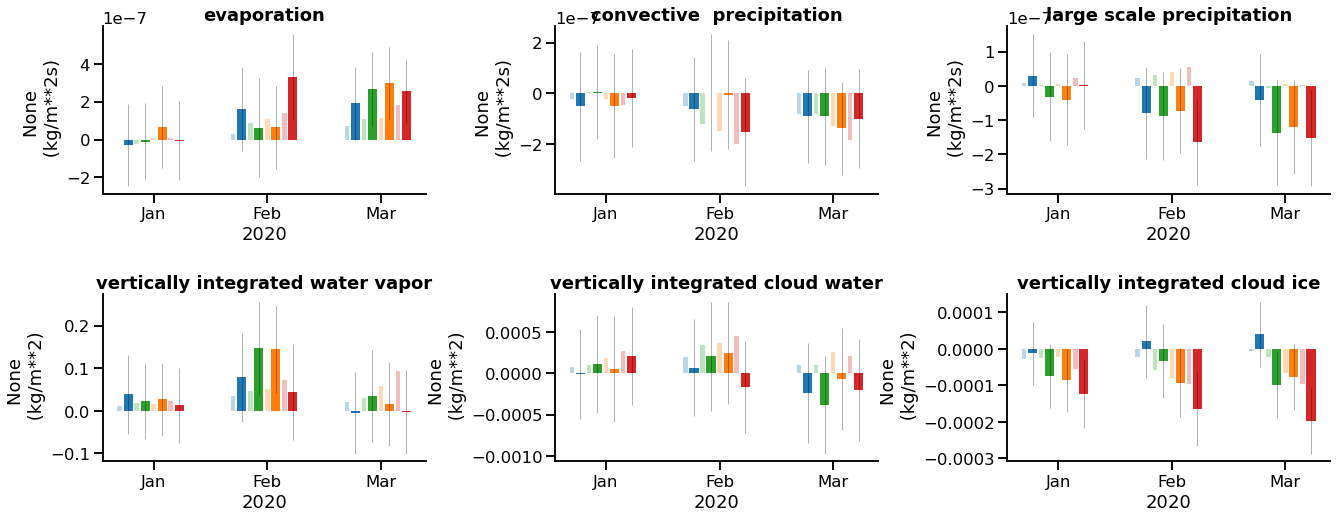

In [24]:
fig, axs = plt.subplots( ncols = 3, nrows = 2, figsize = (22,8))
plt.subplots_adjust( wspace = 0.4, hspace = 0.6)
axs = axs.flatten()

vlist = ['evap', 'aprc', 'aprl', 'qvi', 'xlvi', 'xivi']

for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff_ts(dset[vlist[i]], method = 'globalmean', style = 'bar', add_nudged = True)


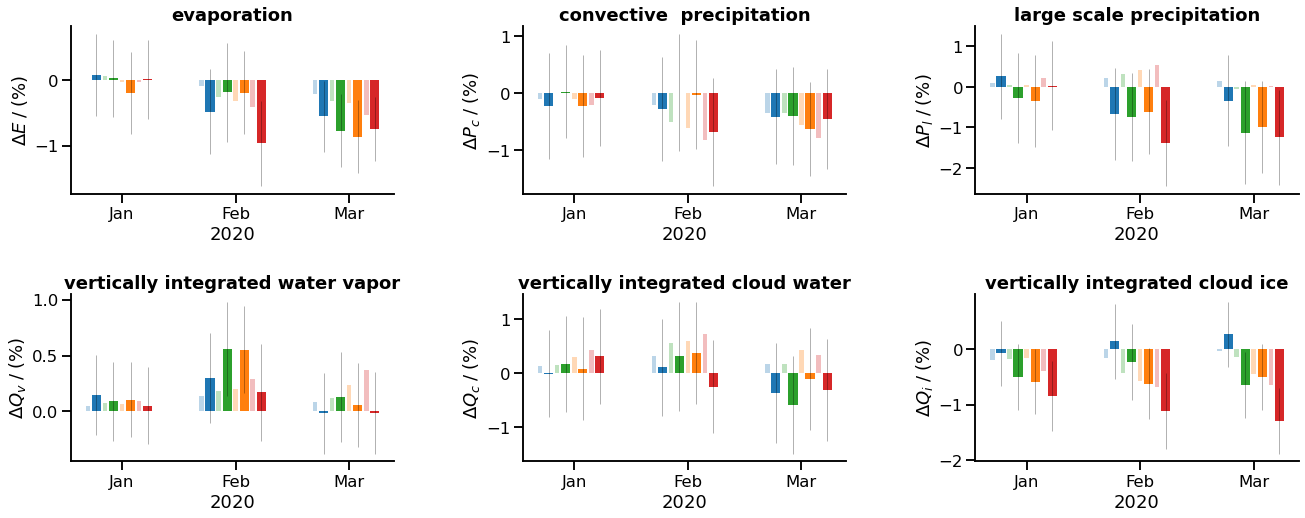

In [48]:
fig, axs = plt.subplots( ncols = 3, nrows = 2, figsize = (22,8))
plt.subplots_adjust( wspace = 0.4, hspace = 0.6)
axs = axs.flatten()

vlist = ['evap', 'aprc', 'aprl', 'qvi', 'xlvi', 'xivi']
labellist = ['E', 'P_c', 'P_l', 'Q_v', 'Q_c', 'Q_i']

for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff_ts(dset[vlist[i]], method = 'globalmean', style = 'bar', add_nudged = True, relative = True)
    axs[i].set_ylabel('$\Delta %s\;/\;(%s)$' % (labellist[i], '\%'))
    
plt.savefig('../pics4paper/hydro-vars.png', dpi = 400)

### Cloud Cover Vars

For cloud cover overlap assumption see e.g. :
    Morcrette, J., and Jakob, C. (2000). The Response of the ECMWF Model to Changes in the Cloud Overlap Assumption. Monthly Weather Review 128, 6, 1707-1732, available from: < https://doi.org/10.1175/1520-0493(2000)128<1707:TROTEM>2.0.CO;2> [Accessed 23 November 2022] 

In [25]:
A = dset['hyam'].rename({'nhym':'lev'})
B = dset['hybm'].rename({'nhym':'lev'})

p = A + B * dset['aps']


In [26]:
cc = dset['aclcac']
cc_low = cc.where( p > 700e2 )
cc_mid = cc.where( np.logical_and(p < 700e2, p > 400e2) )
cc_high = cc.where( p < 400e2 )


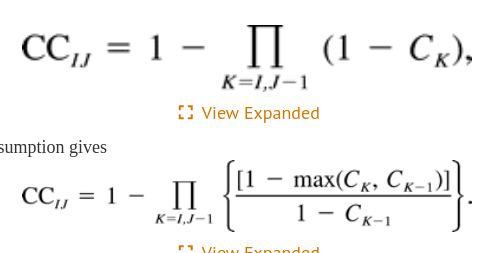

In [27]:
def cloud_cover( cc, overlap = 'random' ):
    
    if overlap == 'random':
        return 1 - (1 - cc).prod('lev')
    
    elif overlap == 'maximum random':
        cc_max = cc.rolling( lev = 2, ).max('lev')
        
        kernel = (1 - cc_max) / (1 - cc)
        return 1 - kernel.prod('lev')

In [28]:
dset['cc_tot_random'] = cloud_cover( cc )
dset['cc_low_random'] = cloud_cover(cc_low)
dset['cc_mid_random'] = cloud_cover(cc_mid)
dset['cc_high_random'] = cloud_cover(cc_high)


In [29]:
dset['cc_tot_maxrandom'] = cloud_cover( cc, overlap = 'maximum random' )
dset['cc_low_maxrandom'] = cloud_cover(cc_low, overlap = 'maximum random')
dset['cc_mid_maxrandom'] = cloud_cover(cc_mid, overlap = 'maximum random')
dset['cc_high_maxrandom'] = cloud_cover(cc_high, overlap = 'maximum random')


/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


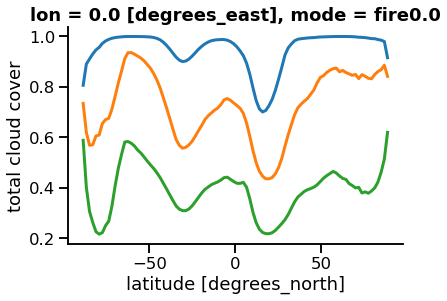

In [30]:
dset['cc_tot_random'].sel(mode = 'fire0.0').mean(('time', 'ensemble')).squeeze().plot()
dset['cc_tot_maxrandom'].sel(mode = 'fire0.0').mean(('time', 'ensemble')).squeeze().plot()

dset['aclcov'].sel(mode = 'fire0.0').mean(('time', 'ensemble')).squeeze().plot()


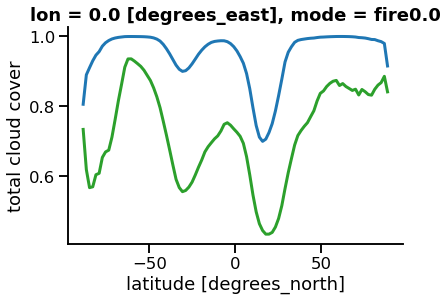

In [31]:
dset['cc_tot_random'].sel(mode = 'fire0.0').mean(('time', 'ensemble')).squeeze().plot()
dset['aclcov'].sel(mode = 'fire0.0').mean(('time', 'ensemble')).squeeze().plot()


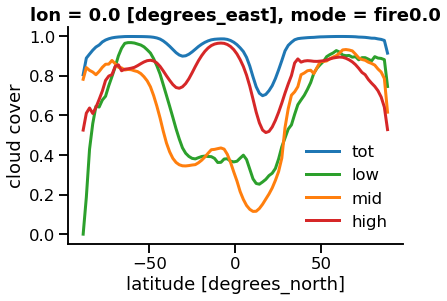

In [32]:
for vname in ['tot', 'low', 'mid', 'high']:
    dset[f'cc_{vname}_random'].sel(mode = 'fire0.0').mean(('time', 'ensemble')).squeeze().plot(label = vname)
plt.legend()

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


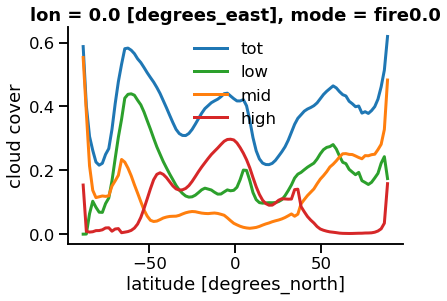

In [33]:
for vname in ['tot', 'low', 'mid', 'high']:
    dset[f'cc_{vname}_maxrandom'].sel(mode = 'fire0.0').mean(('time', 'ensemble')).squeeze().plot(label = vname)
plt.legend()

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


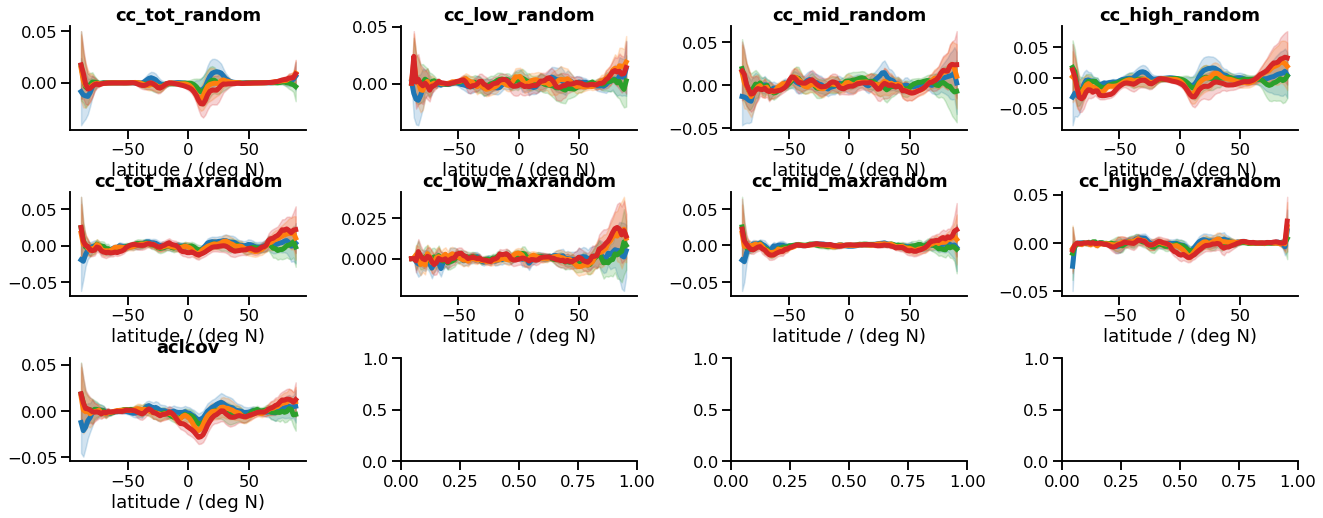

In [34]:
fig, axs = plt.subplots( ncols = 4, nrows = 3, figsize = (22,8))
plt.subplots_adjust( wspace = 0.4, hspace = 0.6 )
axs = axs.flatten()

vlist = [ 'cc_tot_random', 'cc_low_random', 'cc_mid_random','cc_high_random',
         'cc_tot_maxrandom', 'cc_low_maxrandom', 'cc_mid_maxrandom','cc_high_maxrandom', 'aclcov',]

for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff(dset[vlist[i]], )
    plt.title(vlist[i])
    #axs[i].set_ylim(-1,1)

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


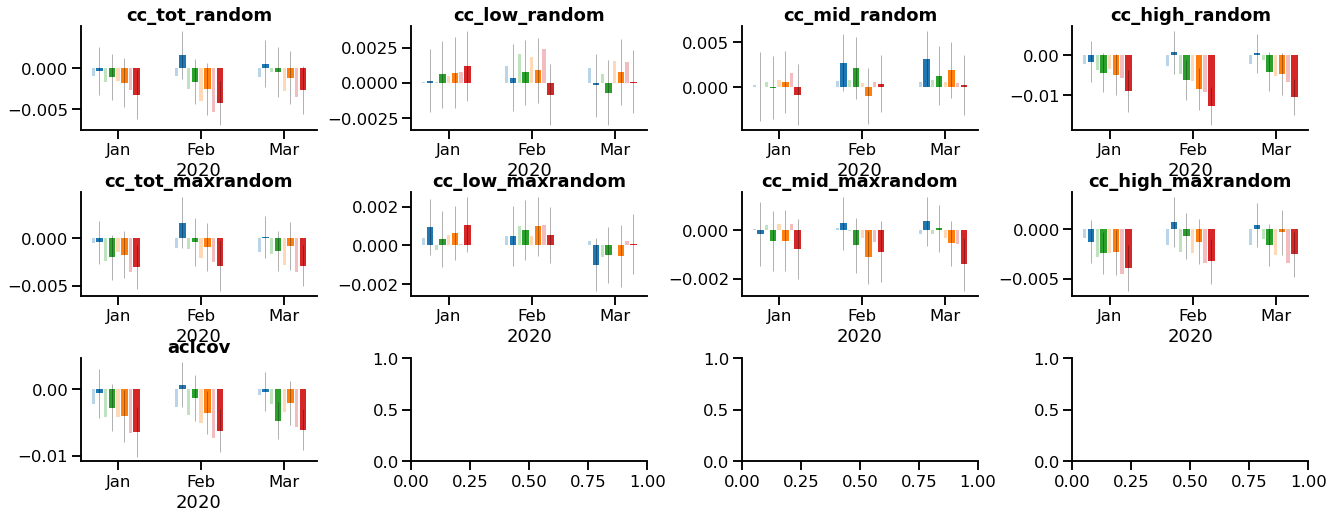

In [35]:
fig, axs = plt.subplots( ncols = 4, nrows = 3, figsize = (22,8))
plt.subplots_adjust( wspace = 0.4, hspace = 0.6 )
axs = axs.flatten()

vlist = [ 'cc_tot_random', 'cc_low_random', 'cc_mid_random','cc_high_random',
         'cc_tot_maxrandom', 'cc_low_maxrandom', 'cc_mid_maxrandom','cc_high_maxrandom', 'aclcov',]

for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff_ts(dset[vlist[i]], method = 'globalmean', style = 'bar', add_nudged = True)
    plt.title(vlist[i])
    #axs[i].set_ylim(-1,1)

**Take-aways**

* radiation:
    - no significant change in the SW radiation part that is unaffected by aerosols


* cloud cover:
    - total CC: reduces
    - low & mid-level CC: highly uncertain
    - high CC: reduces and is mainly responsible